# Классификация с алгоритмом "Случайный лес"

In [19]:
from razdel import tokenize
from pyxdameraulevenshtein import normalized_damerau_levenshtein_distance
import textdistance as j
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean
from sklearn import preprocessing
import numpy as np
from itertools import product
from collections import defaultdict
import pulp
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
from string import punctuation
from collections import defaultdict
import fasttext
import scipy
import joblib

punct = punctuation+'«»—…“”*–'

## 1. Функции для извлечения признаков из векторов слов

In [40]:
def tokenize_query(query):
    line = query.strip()
    tokens = list(tokenize(line))
    tokens = [_.text.lower() for _ in tokens]         
    tokens = [i for i in tokens if i not in punct]
    return tokens

In [5]:
# расстояние Дамерау-Левенштейна

def levenstein(q1, q2):
    return normalized_damerau_levenshtein_distance(q1, q2)

In [6]:
# расстояние Монге-Эклан

class MongeElkan():
    '''
    Accepts the inner similarity function
    '''
    def __init__(self):
        pass
    
    def score(self,s,t,m):
        '''
        Input: s - multi-word string
               t - multi-word string
               m - power
        Output : score
        Note: In single word string, score = jaro-winkler score
        '''
        cummax = 0
        
        for ws in tokenize_query(s):
            maxscore=0
            for wt in tokenize_query(t):
                maxscore = max(maxscore,(j.jaro_winkler(ws,wt))**m)
            cummax += maxscore
        
        return (cummax/len(tokenize_query(s)))**(1/m)
    
def monge_eklan(q1, q2):
    m = MongeElkan()
    return 1 - m.score(q1, q2, m=2)

In [7]:
# word overlap

def overlap(q1, q2):
    q1 = set(tokenize_query(q1))
    q2 = set(tokenize_query(q2))
    denom = (len(q1) + len(q2))/2
    if denom == 0:
        return 1.0
    overlap_ratio = 1 - (len(q1 & q2)/denom)
    return overlap_ratio

In [8]:
# косинусное расстояние

def cosine_dist(vec1, vec2): 
    return 1 - cosine(vec1, vec2)

In [9]:
# евклидово расстояние

def euclid(vec1, vec2, f_model=None):
    vecs = preprocessing.normalize([vec1, vec2], norm='l2')
    return 1 - scipy.spatial.distance.euclidean(vecs[0], vecs[1])

In [10]:
# метрики на основе матрицы смежности

def count_scores(q1, q2, model, similarity_function): # model - fasttext model
    q1_tokens = tokenize_query(q1)
    q2_tokens = tokenize_query(q2)
    
    # заполняем матрицу расстояний
    sim_scores = []
    for i,w_1 in enumerate(q1_tokens):
        cur_sim_scores = []
        for j,w_2 in enumerate(q2_tokens):
            score = similarity_function(model.get_word_vector(w_1), model.get_word_vector(w_2))
            cur_sim_scores.append(score)
        sim_scores.append(cur_sim_scores)
    
    sim_scores = np.matrix(sim_scores)
    
    # считаем и возвращаем 4 признака
    max_similar = np.max(sim_scores)
    max_similar_idx = np.where(sim_scores == max_similar)
    min_similar = np.min(sim_scores[max_similar_idx[0]])
    
    min_dissimilar = np.min(sim_scores)
    min_dissimilar_idx = np.where(sim_scores == min_dissimilar)
    max_dissimilar = np.max(sim_scores[min_dissimilar_idx[0]])
    
    return max_similar, min_similar, min_dissimilar, max_dissimilar

In [11]:
# пример
model = fasttext.load_model("../model-20-min-freq-3.bin")

In [14]:
res = count_scores("айфон купить бу", "iphone", model, cosine_dist)
res

(0.9037832021713257,
 0.9037832021713257,
 0.1575290560722351,
 0.1575290560722351)

In [15]:
# соберем словарь idf по корпусу заголовков объявлений
freq_dict = defaultdict(int)
document_count = 0

prev_line = None

for line in tqdm(open("/Users/amnikolaeva/hse/diplom/fastText-0.9.1/cleaned_titles_full.txt", "r")):
    
    if line == prev_line:
        continue
    prev_line = line
    
    tokens = line.split()
    for t in tokens:
        freq_dict[t] += 1
        
    document_count += 1

In [16]:
len(freq_dict), document_count

(2485667, 54532823)

In [20]:
# функция подсчета idf слов запроса

def idf(query):
    tokens = tokenize_query(query)
    idf_scores = []
    for token in tokens:
        if freq_dict[token] == 0:            
            idf_scores.append(-np.log(1/document_count))
            continue
        idf_scores.append(-np.log(freq_dict[token]/document_count))
    return idf_scores

In [24]:
# метрики на основе матрицы разниц idf

def count_idf_scores(q1, q2):
    vec1 = idf(q1)
    vec2 = idf(q2)
    
    diffs = []
    for i,w_1 in enumerate(vec1):
        cur_diffs = []
        for j,w_2 in enumerate(vec2):
            score = w_1-w_2 # чем меньше разница в векторах, тем 2 слова ближе в векторном пространстве
            cur_diffs.append(score)
        diffs.append(cur_diffs)
    
    diff_scores = np.matrix(diffs)
    
    max_similar = np.max(diff_scores)
    max_similar_idx = np.where(diff_scores == max_similar)
    min_similar = np.min(diff_scores[max_similar_idx[0]])
    
    min_dissimilar = np.min(diff_scores)
    min_dissimilar_idx = np.where(diff_scores == min_dissimilar)
    max_dissimilar = np.max(diff_scores[min_dissimilar_idx[0]])
    
    return max_similar, min_similar, min_dissimilar, max_dissimilar

##  2. Функция для рассчета всех признаков

In [22]:
# загружаем заранее извлеченные вектора fasttext для слов из тренировочного корпуса 

tok2vec = joblib.load("../../classification/token2vec.pkl") 

In [38]:
def get_features(pairs):
    vecs = []
    for q1, q2 in tqdm(pairs):
        cur_vec = []
        cur_vec.append(cosine_dist(
            model.get_sentence_vector(" ".join(tokenize_query(q1))), 
            model.get_sentence_vector(" ".join(tokenize_query(q2)))
        ))
        cur_vec.append(euclid(
            model.get_sentence_vector(" ".join(tokenize_query(q1))), 
            model.get_sentence_vector(" ".join(tokenize_query(q2)))
        ))
        cur_vec.append(levenstein(q1,q2))
        cur_vec.append(monge_eklan(q1,q2))
        cur_vec.append(overlap(q1,q2))
        cur_vec.extend(count_scores(q1,q2,model,cosine_dist))
        # cur_vec.extend(count_scores(q1,q2,model_f,euclid))
        cur_vec.extend(count_idf_scores(q1,q2))
        cur_vec.append(len(tokenize_query(q1)))
        cur_vec.append(len(tokenize_query(q1)))
        vecs.append(cur_vec)
    return vecs

## 3. Бинарная классификация

In [207]:
train = pd.read_csv("../../classification/train.tsv", sep="\t")

In [208]:
train = train.sample(frac=1)
pairs = train[["prev_query", "query"]].values.tolist()
tags = [0 if i in [0,3] else i for i in train.tag]
test = pd.read_csv("../../classification/test.tsv", sep="\t")
test_pairs = test[["prev_query", "query"]].values.tolist()

In [209]:
def binary_tag(x):
    return 1 if x == 0 else 0

train["new_binary_tag"] = train["binary_tag"].apply(binary_tag)
test["new_binary_tag"] = test["binary_tag"].apply(binary_tag)

In [210]:
vecs = get_features(pairs)

In [234]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=20, 
                             n_estimators=100, 
                             class_weight={0:0.7, 1:0.3}, 
                             bootstrap=True, 
                             verbose=1, 
                             criterion="entropy",
                             oob_score=True
                            )
clf.fit(vecs, train.new_binary_tag)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished


RandomForestClassifier(bootstrap=True, class_weight={0: 0.7, 1: 0.3},
            criterion='entropy', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=True,
            random_state=None, verbose=1, warm_start=False)

In [229]:
test_vecs = get_features(test_pairs)

In [237]:
pred = clf.predict(test_vecs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [238]:
print(classification_report(test.new_binary_tag, pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89       473
           1       0.70      0.84      0.76       202

   micro avg       0.85      0.85      0.85       675
   macro avg       0.81      0.84      0.83       675
weighted avg       0.86      0.85      0.85       675



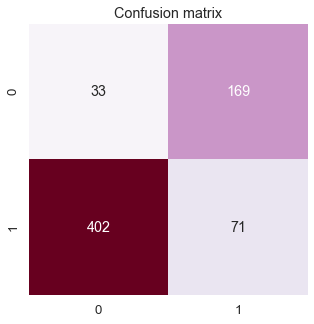

              precision    recall  f1-score   support

           0       0.92      0.85      0.89       473
           1       0.70      0.84      0.76       202

   micro avg       0.85      0.85      0.85       675
   macro avg       0.81      0.84      0.83       675
weighted avg       0.86      0.85      0.85       675



In [239]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

m = confusion_matrix(test.binary_tag, pred)

labels = clf.classes_
plt.figure(figsize = (5,5))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuRd")
plt.title("Confusion matrix")
plt.show()

print(classification_report(test.new_binary_tag, pred))

## 4. Трехклассовая классификация - голосование 3 моделей для каждого класса: один класс против всех

In [241]:
# уберем примеры только с бинарной разметкой
train = train[train["source"]!='binary-tag-edit-dist']

## 4.1 Предскажем класс 0

In [242]:
train = train.sample(frac=1)
pairs = train[["prev_query", "query"]].values.tolist()
tags = [0 if i in [0,3] else i for i in train.tag]
test = pd.read_csv("../../classification/test.tsv", sep="\t")
test_pairs = test[["prev_query", "query"]].values.tolist()

In [243]:
def binary_tag(x):
    return 1 if x == 0 else 0

train["new_binary_tag"] = train["binary_tag"].apply(binary_tag)
test["new_binary_tag"] = test["binary_tag"].apply(binary_tag)

In [245]:
vecs = get_features(pairs)

In [246]:
test_vecs = get_features(test_pairs)

In [248]:
train.groupby("binary_tag").tag.count()/len(train)

binary_tag
0    0.435996
1    0.564004
Name: tag, dtype: float64

In [249]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=20, 
                             n_estimators=100, 
                             class_weight={0:0.43, 1:0.56}, 
                             bootstrap=True, 
                             random_state=0, 
                             verbose=1, 
                             criterion="entropy",
                             oob_score=True
                            )
clf.fit(vecs, train.new_binary_tag)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished


RandomForestClassifier(bootstrap=True, class_weight={0: 0.43, 1: 0.56},
            criterion='entropy', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=True, random_state=0,
            verbose=1, warm_start=False)

In [250]:
binary_tag_proba = clf.predict_proba(test_vecs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [251]:
pred = clf.predict(test_vecs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [252]:
print(classification_report(test.new_binary_tag, pred))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       473
           1       0.69      0.82      0.75       202

   micro avg       0.84      0.84      0.84       675
   macro avg       0.80      0.83      0.81       675
weighted avg       0.85      0.84      0.84       675



## 4.2 Класс 0 уже предсказали, предскажем класс 2 (синоним)

In [253]:
def synonym_tag(x):
    return 1 if x == 2 else 0


train["binary_synonym_tag"] = train["tag"].apply(synonym_tag)

In [254]:
train.groupby("binary_synonym_tag").tag.count()/len(train)

binary_synonym_tag
0    0.75004
1    0.24996
Name: tag, dtype: float64

In [255]:
clf = RandomForestClassifier(max_depth=100, 
                             n_estimators=100, 
                             bootstrap=True, 
                             verbose=1, 
                             criterion="entropy",
                             random_state=0,
                             class_weight={0:0.75, 1:0.25},
                            )
clf.fit(vecs, train.binary_synonym_tag)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


RandomForestClassifier(bootstrap=True, class_weight={0: 0.75, 1: 0.25},
            criterion='entropy', max_depth=100, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False, random_state=0,
            verbose=1, warm_start=False)

In [256]:
test["binary_synonym_tag"] = test["tag"].apply(synonym_tag)
pred = clf.predict(test_vecs)
print(classification_report(test.binary_synonym_tag, pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       510
           1       0.63      0.35      0.45       165

   micro avg       0.79      0.79      0.79       675
   macro avg       0.72      0.64      0.66       675
weighted avg       0.77      0.79      0.77       675



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [257]:
synonym_class_proba = clf.predict_proba(test_vecs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


## 4.2. Предскажем класс 1 (переформулировка)

In [258]:
def ref_tag(x):
    return 1 if x == 1 else 0


train["binary_ref_tag"] = train["tag"].apply(ref_tag)
test["binary_ref_tag"] = test["tag"].apply(ref_tag)

In [265]:
clf = RandomForestClassifier(max_depth=20, 
                             n_estimators=100, 
                             bootstrap=True, 
                             random_state=0, 
                             verbose=1, 
                             criterion="entropy",
                             oob_score=True
                            )
clf.fit(vecs, train.binary_ref_tag)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=0, verbose=1, warm_start=False)

In [266]:
pred = clf.predict(test_vecs)
print(classification_report(test.binary_ref_tag, pred))

              precision    recall  f1-score   support

           0       0.72      0.86      0.78       367
           1       0.78      0.59      0.67       308

   micro avg       0.74      0.74      0.74       675
   macro avg       0.75      0.73      0.73       675
weighted avg       0.75      0.74      0.73       675



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [267]:
ref_class_proba = clf.predict_proba(test_vecs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


## Голосование моделей

In [268]:
# индекс = 0 -> разный интент - 3
# индекс = 1 -> переформулировка - 1
# индекс = 2 -> синоним - 2


test_3_class_preds = []
for i in range(len(test)):
    probs = [binary_tag_proba[i][1], ref_class_proba[i][1], synonym_class_proba[i][1]]
    max_prob = max(probs)
    idx = probs.index(max_prob)
    if idx == 0:
        test_3_class_preds.append(3)
    if idx == 1:
        test_3_class_preds.append(1)   
    if idx == 2:
        test_3_class_preds.append(2)   

In [269]:
test["3_class_preds"] = test_3_class_preds

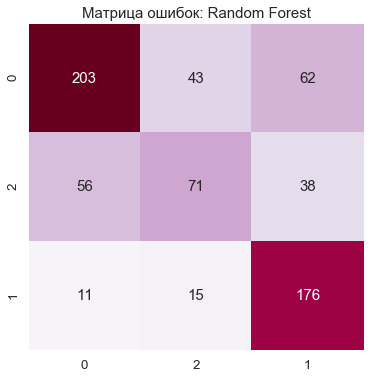

              precision    recall  f1-score   support

           1       0.75      0.66      0.70       308
           2       0.55      0.43      0.48       165
           3       0.64      0.87      0.74       202

   micro avg       0.67      0.67      0.67       675
   macro avg       0.65      0.65      0.64       675
weighted avg       0.67      0.67      0.66       675



In [271]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

m = confusion_matrix(test.tag, test["3_class_preds"])
sns.set(font_scale=1.2)
plt.figure(figsize = (6,6))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, 
            xticklabels=[0, 2, 1], 
            yticklabels=[0, 2, 1], 
            cmap="PuRd",
           annot_kws={"size": 15})
plt.title("Матрица ошибок: Random Forest", fontsize=15)
plt.show()

print(classification_report(test.tag, test["3_class_preds"]))